DSS THESIS

*Packages and preparation*

In [1]:
# importing packages
from datetime import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np # for mathematical operations
import pandas as pd # for dataframe processing
import re
import seaborn as sns
import sklearn
from sklearn import metrics
from sklearn import model_selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import spacy
import string
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

pd.options.display.max_columns = None
seed = 123456

*Dataframe initialization*

In [2]:
# loading dataframes /anti /pro

antidf = pd.read_csv('anti.csv', sep = ";", index_col = 0, low_memory = False)
prodf = pd.read_csv('pro.csv', sep = ";", index_col = 0, low_memory = False)

In [3]:
# coding sentiment
antidf['sentiment'] = np.ones(antidf.shape[0]) # coding 1 for negative sentiment
prodf['sentiment'] = np.zeros(prodf.shape[0]) # coding 0 for positive sentiment

# merging dataframes for main dataframe
full_df = pd.concat([antidf, prodf])

EDA & Data cleaning

In [4]:
# is na
(full_df.isna().sum()*100/len(full_df)).round(2)

coordinates                    99.92
created_at                      0.00
hashtags                       29.00
media                          90.15
urls                           88.41
favorite_count                  0.00
id                              0.00
in_reply_to_screen_name        93.04
in_reply_to_status_id          93.48
in_reply_to_user_id            93.04
lang                            0.00
place                          99.10
possibly_sensitive             80.04
quote_id                       89.16
retweet_count                   0.00
retweet_id                     30.40
retweet_screen_name            30.40
source                          0.00
text                            0.00
tweet_url                       0.00
user_created_at                 0.00
user_id                         0.00
user_default_profile_image      0.00
user_description               19.60
user_favourites_count           0.00
user_followers_count            0.00
user_friends_count              0.00
u

In [5]:
# to account for retweets and duplicates
full_df['text'].nunique()*100/len(full_df)

31.56388373274709

In [6]:
# removing duplicated in text
full_df.drop_duplicates(subset = ['text'], keep = 'first', inplace = True)

In [7]:
# removing columns with notna < 0.5
full_df.dropna(axis = 'columns', thresh = (full_df.shape[0]*0.5), inplace = True)

In [8]:
# dropping nas in rows
full_df = full_df[full_df['user_description'].notna()]

# removing noisy variables
# user_location = rarely available
# lang = same value all over
# names, id, and user created at - identifing author
# user desctiption, extra textual variable 
# hashtags correlation too high
full_df.drop(columns = ['user_location', 'user_description', 'lang', 'user_screen_name', 'source', 'tweet_url', 
                        'user_id', 'user_name', 'hashtags', 'user_created_at', 'id'], inplace = True)

In [9]:
# cleaning date variable

# defining get date function
def getdate(x):
    dt = parse(x)
    return dt.date()

# applying get date function
full_df['created_at'] = full_df['created_at'].apply(lambda x: getdate(x))

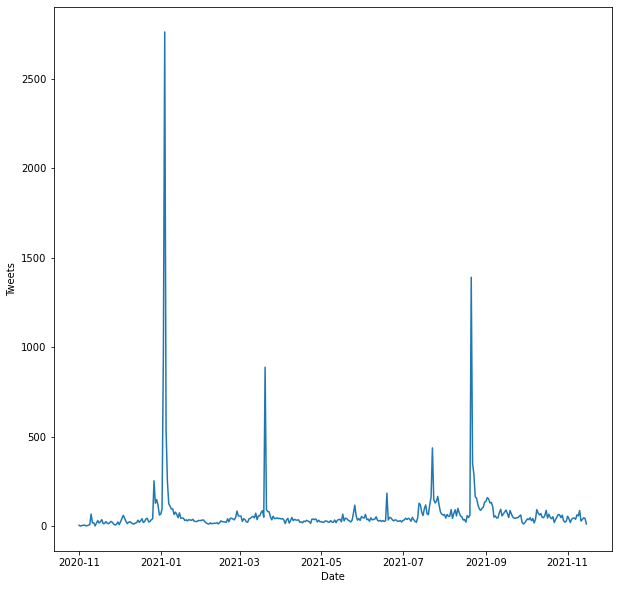

In [10]:
# plotting time range + sentiment
# distribution
dist = full_df['sentiment'].groupby(full_df['created_at'])

# figure
fig = plt.figure(figsize=(10,10)) # size
plt.xlabel('Date')
plt.ylabel('Tweets')
# plt.title('Tweet distribution per date') # title
plt.plot(dist.count(), linestyle = 'solid') # plot
#fig.savefig('dates.png', dpi=fig.dpi) # save

In [11]:
# datetime to integer for model purposes
full_df['created_at'] = pd.to_datetime(full_df["created_at"]).dt.strftime("%Y%m%d").astype(int)

In [12]:
# on to text variable 
# defining cleaning text function
def clean_text(text):
    if type(text) == float:
        return ""
    temp = text.lower() #to lowercase all text
    temp = re.sub("'", " ", temp) # to avoid removing contractions
    temp = re.sub("@[a-z0-9_]+","", temp) # to remove mentions
    temp = re.sub("#[a-z0-9_]+","", temp) # to remove hashtags
    temp = re.sub(r'http\S+', '', temp) # to remove links
    temp = re.sub(r"www.\S+", "", temp) # to remove links
    temp = re.sub('\n', ' ', temp) # to remove enters
    temp = re.sub('[^a-z0-9àèìòù]', ' ', temp) # to remove non-alphanumeric characters
    temp = re.sub('[()!?]', ' ', temp) # to remove punctuation
    temp = re.sub('\[.*?\]',' ', temp) # to remove punctuation
    temp = temp.split() # tokenization
    temp = [w for w in temp if not w in stopwords.words("italian")] # to remove stopwords
    temp = " ".join(word for word in temp) # to rejoin tokens
    return temp

# defining lemmatization function
nlp = spacy.load('it_core_news_lg')
def lemmatization(inp):
    if type(inp) == None:
        return ""
    doc = nlp(inp)
    return " ".join(token.lemma_ for token in doc)

In [13]:
# applying cleaning text function to text
full_df['clean_text'] = full_df['text'].apply(lambda x:clean_text(x))

# applying lemmatization function to text and user description
full_df['lemmatized_text'] = full_df['clean_text'].apply(lambda x: lemmatization(x))

# dropping recoded variables
full_df.drop(columns = ['text', 'clean_text'], inplace = True)

In [14]:
# distribution of sentiment on clean df
full_df['sentiment'].value_counts()

0.0    13116
1.0    12915
Name: sentiment, dtype: int64

In [15]:
# resampling clean df with balanced sentiment classes
full_df = full_df.groupby('sentiment').sample(n = 12500, random_state = seed).reset_index(drop = True)

# shuffling clean df
full_df = full_df.sample(frac = 1, random_state = seed).reset_index(drop = True)

In [16]:
full_df.to_csv('dss_thesis_full_finaldata.csv', sep = ";")

*Dataframe initialization + baseline*

In [17]:
df = pd.read_csv('dss_thesis_full_finaldata.csv',  sep = ";" ,index_col = 0, low_memory = False)
df = df.fillna(" ")

In [18]:
df

,created_at,favorite_count,retweet_count,user_default_profile_image,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_statuses_count,user_verified,sentiment,lemmatized_text
0,20210711,1,0,False,1061,73,83,0,1402,False,0.0,ieri sabato 10 luglio 449 590 vaccinazione ecc...
1,20210311,0,5,False,59010,5094,1094,126,198424,False,0.0,propaganda fare vaccino vergognoso spiace part...
2,20210912,0,0,False,462,18,57,0,195,False,0.0,continuare parlare accorgere dato convergere v...
3,20210921,0,0,False,1765,50,79,0,2649,False,1.0,dissocio
4,20210706,0,114,False,69958,449,509,4,43962,False,1.0,art 36 regolamento europeo scritto andare evit...
...,...,...,...,...,...,...,...,...,...,...,...,...
24995,20210831,14,0,False,16860,13730,2666,45,15164,False,0.0,dispiacere morte poliziotto taranto morire con...
24996,20210317,0,4,False,3767,471,1408,32,6925,False,0.0,sicilia sempre additare disorganizzazione appa...
24997,20210629,0,9,False,8883,1232,1117,1,16099,False,1.0,infatti capisco resistere fronte minaccia dipe...
24998,20211011,0,0,False,2,28,88,0,202,False,1.0,coloro vaccinare marionetta Stato perché secon...


In [19]:
# a baseline model evaluation
X = df[(col for col in df if col != 'sentiment')]
y = df['sentiment']

X_train_dum, X_test_dum, y_train_dum, y_test_dum = train_test_split(X, y, test_size=0.20, random_state=seed)

dummy_clf = DummyClassifier(strategy="stratified").fit(X_train_dum, y_train_dum)
y_pred_dum = dummy_clf.predict(X_test_dum)
print(dummy_clf.score(X_test_dum, y_test_dum))
print(confusion_matrix(y_pred_dum, y_test_dum))

0.5154
[[1207 1306]
 [1263 1224]]


Data preprocessing

In [20]:
dfbow = df.copy(deep=True)
dftf = df.copy(deep=True)

In [21]:
# count vectorizer - tfidf parameters + encoding + concatenation
cvectorizer = CountVectorizer(max_features = 1000, binary = True) # counting words with binary condition
tfvectorizer = TfidfVectorizer(max_features = 1000)

textbow = cvectorizer.fit_transform(df['lemmatized_text']).todense() # step 1: encode variable + to dense
textbow = pd.DataFrame(textbow, columns=cvectorizer.get_feature_names_out()) # step 2: matrix to dataframe w/ col names

texttf = tfvectorizer.fit_transform(df['lemmatized_text']).todense() # step 1: encode variable + to dense
texttf = pd.DataFrame(texttf, columns=tfvectorizer.get_feature_names_out()) # step 2: matrix to dataframe w/ col names

dfbow = pd.concat([dfbow, textbow], axis=1)
dfbow.drop(columns = ['lemmatized_text'], inplace = True)
dftf = pd.concat([dftf, texttf], axis=1)
dftf.drop(columns = ['lemmatized_text'], inplace = True)

In [22]:
# df A
X_bow = dfbow[(col for col in dfbow if col != 'sentiment')]
y_bow = dfbow['sentiment']

X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, y_bow, test_size=0.20, random_state=seed)

# df B
X_tf = dftf[(col for col in dftf if col != 'sentiment')]
y_tf = dftf['sentiment']

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y_tf, test_size=0.20, random_state=seed)

In [23]:
# model 1
param_grid_nb = {'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 1e-05)}

grid_nb = GridSearchCV(estimator = MultinomialNB(),
                       param_grid = param_grid_nb,
                       scoring = 'accuracy',
                       cv = 10,
                       n_jobs = -1,
                      )

param_grid_rf = {'n_estimators': [10, 50, 100],
                 'max_features': ['log2', 'sqrt'],
                 'max_depth': [None, 10, 50],
                 'bootstrap': [True, False]}

# model 2
grid_rf = GridSearchCV(estimator = RandomForestClassifier(),
                       param_grid = param_grid_rf,
                       scoring = 'accuracy',
                       cv = 10,
                       n_jobs = -1,
                      )

param_grid_etc = {'n_estimators': [10, 50, 100],
                  'max_features': ['log2', 'sqrt'],
                  'max_depth': [None, 10, 50],
                  'bootstrap': [True, False]}

# model 3
grid_etc = GridSearchCV(estimator = ExtraTreesClassifier(),
                        param_grid = param_grid_etc,
                        scoring = 'accuracy',
                        cv = 10,
                        n_jobs = -1,
                       )

In [24]:
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test_tf))]
p_fpr, p_tpr, _ = roc_curve(y_test_bow, random_probs, pos_label=1)

Training execution time is:  0:00:19.925339
Prediction execution time is:  0:00:00.282837
{'alpha': 1}
              precision    recall  f1-score   support

    positive       0.56      0.33      0.41      2470
    negative       0.53      0.75      0.62      2530

    accuracy                           0.54      5000
   macro avg       0.55      0.54      0.52      5000
weighted avg       0.55      0.54      0.52      5000

[[ 804 1666]
 [ 630 1900]]
Training execution time is:  0:07:55.833654
Prediction execution time is:  0:00:00.514463
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
              precision    recall  f1-score   support

    positive       0.91      0.90      0.91      2470
    negative       0.91      0.91      0.91      2530

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000

[[2233  237]
 [ 221 2309]]
Training execu

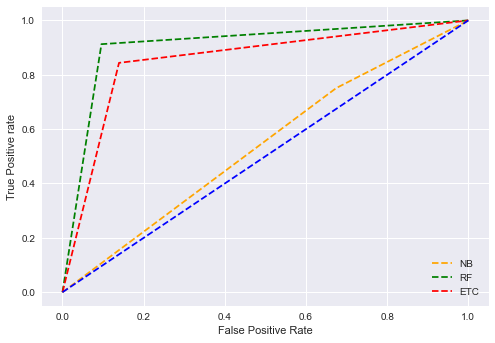

In [25]:
# bow model eval
models = [('NB', grid_nb),
          ('RF', grid_rf),
          ('ETC', grid_etc)
         ]
y_pred_bow =  []
pred_bow = []
names = []
target_names = ['positive', 'negative']

for name, model in models:
    start1 = datetime.now() 
    clf = model.fit(X_train_bow,y_train_bow)
    stop1 = datetime.now()
    fit_execution_time = stop1-start1
    print("Training execution time is: ", fit_execution_time)
    start2 = datetime.now() 
    y_pred_bow = clf.predict(X_test_bow)
    stop2 = datetime.now()
    pred_execution_time = stop2-start2
    print("Prediction execution time is: ", pred_execution_time)
    pred_bow.append(y_pred_bow)
    print(model.best_params_)
    print(classification_report(y_test_bow, y_pred_bow, target_names=target_names))
    print(confusion_matrix(y_test_bow, y_pred_bow))
    names.append(name)    
    
# roc curve for models
fpr1_bow, tpr1_bow, thresh1_bow = roc_curve(y_test_bow, pred_bow[0], pos_label=1)
fpr2_bow, tpr2_bow, thresh2_bow= roc_curve(y_test_bow, pred_bow[1], pos_label=1)
fpr3_bow, tpr3_bow, thresh3_bow = roc_curve(y_test_bow, pred_bow[2], pos_label=1)

# auc scores
auc_score1_bow = roc_auc_score(y_test_bow, pred_bow[0]).round(2)
auc_score2_bow = roc_auc_score(y_test_bow, pred_bow[1]).round(2)
auc_score3_bow = roc_auc_score(y_test_bow, pred_bow[2]).round(2)

print(auc_score1_bow, auc_score2_bow, auc_score3_bow)

plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1_bow, tpr1_bow, linestyle='--',color='orange', label=names[0])
plt.plot(fpr2_bow, tpr2_bow, linestyle='--',color='green', label=names[1])
plt.plot(fpr3_bow, tpr3_bow, linestyle='--',color='red', label=names[2])

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# plt.title('BoW ROC curve') # title
plt.xlabel('False Positive Rate') # x label
plt.ylabel('True Positive rate') # y label
plt.legend(loc='best')
plt.savefig('ROCA',dpi=300)
plt.show();

Training execution time is:  0:00:36.631038
Prediction execution time is:  0:00:00.306026
{'alpha': 1}
              precision    recall  f1-score   support

    positive       0.56      0.33      0.41      2470
    negative       0.53      0.75      0.62      2530

    accuracy                           0.54      5000
   macro avg       0.55      0.54      0.52      5000
weighted avg       0.55      0.54      0.52      5000

[[ 804 1666]
 [ 630 1900]]
Training execution time is:  0:10:09.370974
Prediction execution time is:  0:00:01.236199
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
              precision    recall  f1-score   support

    positive       0.91      0.91      0.91      2470
    negative       0.91      0.91      0.91      2530

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000

[[2237  233]
 [ 223 2307]]
Training execu

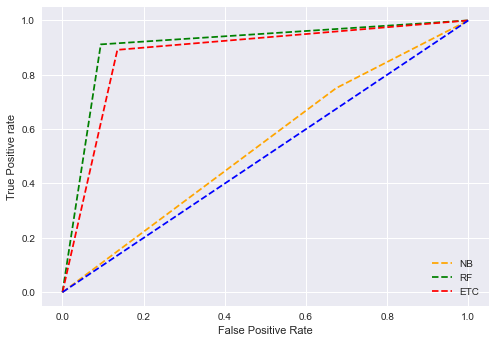

In [26]:
# tf model eval
models = [('NB', grid_nb),
          ('RF', grid_rf),
          ('ETC', grid_etc)
         ]
y_pred_tf =  []
pred_tf = []
names = []
target_names = ['positive', 'negative']

for name, model in models:
    start1 = datetime.now() 
    clf = model.fit(X_train_tf,y_train_tf)
    stop1 = datetime.now()
    fit_execution_time_tf = stop1-start1
    print("Training execution time is: ", fit_execution_time_tf)
    start2 = datetime.now()     
    y_pred_tf = clf.predict(X_test_tf)
    stop2 = datetime.now()
    pred_execution_time_tf = stop2-start2
    print("Prediction execution time is: ", pred_execution_time_tf)
    pred_tf.append(y_pred_tf)
    print(model.best_params_)
    print(classification_report(y_test_tf, y_pred_tf, target_names=target_names))
    print(confusion_matrix(y_test_tf, y_pred_tf))
    names.append(name)    
    
# roc curve for models
fpr1_tf, tpr1_tf, thresh1_tf = roc_curve(y_test_tf, pred_tf[0], pos_label=1)
fpr2_tf, tpr2_tf, thresh2_tf = roc_curve(y_test_tf, pred_tf[1], pos_label=1)
fpr3_tf, tpr3_tf, thresh3_tf = roc_curve(y_test_tf, pred_tf[2], pos_label=1)

# auc scores
auc_score1_tf = roc_auc_score(y_test_tf, pred_tf[0]).round(2)
auc_score2_tf = roc_auc_score(y_test_tf, pred_tf[1]).round(2)
auc_score3_tf = roc_auc_score(y_test_tf, pred_tf[2]).round(2)

print(auc_score1_tf, auc_score2_tf, auc_score3_tf)

plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1_tf, tpr1_tf, linestyle='--',color='orange', label=names[0])
plt.plot(fpr2_tf, tpr2_tf, linestyle='--',color='green', label=names[1])
plt.plot(fpr3_tf, tpr3_tf, linestyle='--',color='red', label=names[2])

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# plt.title('Tf-idf ROC curve') # title
plt.xlabel('False Positive Rate') # x label
plt.ylabel('True Positive rate') # y label
plt.legend(loc='best')
plt.savefig('ROCB',dpi=300)
plt.show();

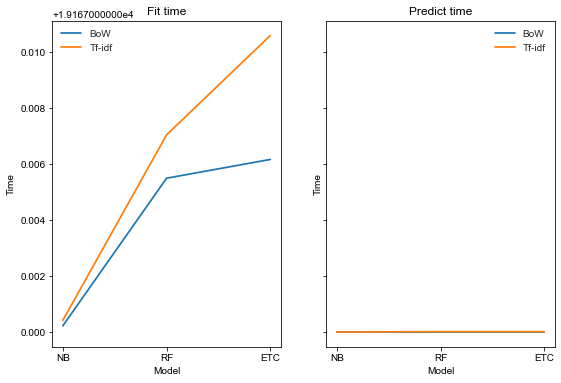

In [2]:
import matplotlib.dates as mdates

fig , ax = plt.subplots(1,2, sharex='col', sharey='row', figsize=(9, 6))
plt.style.use('seaborn')

X = ['NB','RF','ETC']
trainbowtime = mdates.datestr2num(["0:00:19","00:07:55", "0:08:53"])
fitbowtime = mdates.datestr2num(["00:00:00","00:00:00","00:00:00"])
traintftime = mdates.datestr2num(["0:00:36", "0:10:09", "0:15:16"])
fittftime = mdates.datestr2num(["00:00:00", "00:00:01", "00:00:01"])

ax[0].plot(X, trainbowtime , label = 'BoW')
ax[0].plot(X, traintftime , label = 'Tf-idf')
ax[0].set_title('Fit time')
ax[0].legend()
ax[0].set_xlabel("Model")
ax[0].set_ylabel("Time")

ax[1].plot(X, fitbowtime, label = 'BoW')
ax[1].plot(X, fittftime, label = 'Tf-idf')
ax[1].set_title('Predict time')
ax[1].legend()
ax[1].set_xlabel("Model")
ax[1].set_ylabel("Time")

plt.show()
fig.savefig('timecomp', dpi = 300)

In [28]:
dfuser = df[['user_default_profile_image',
             'user_favourites_count',
             'user_followers_count',
             'user_friends_count',
             'user_listed_count',
             'user_statuses_count',
             'user_verified',
             'sentiment']]

dftweet = dfbow.copy(deep=True)
dftweet = dftweet.drop(columns =['user_default_profile_image',
                                 'user_favourites_count',
                                 'user_followers_count',
                                 'user_friends_count',
                                 'user_listed_count',
                                 'user_statuses_count',
                                 'user_verified'])

In [29]:
dftweetcorr = dftweet.corr()[['sentiment']].sort_values(by='sentiment', ascending=False)
dfusercorr = dfuser.corr()[['sentiment']].sort_values(by='sentiment', ascending=False)

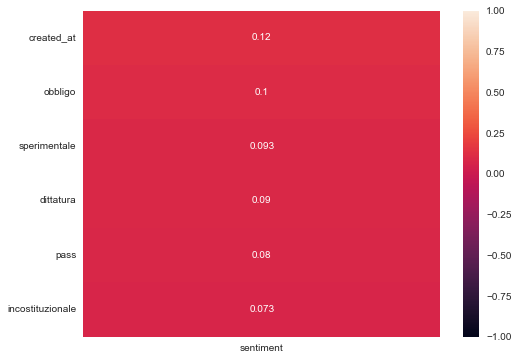

In [30]:
plt.figure(figsize=(8, 6))
plt.style.use('seaborn')

heatmap = sns.heatmap(dftweetcorr[1:7], vmin=-1, vmax=1, annot=True)
# heatmap.set_title('Bow features Correlating with Sentiment', fontdict={'fontsize':11}, pad=16)
plt.yticks(rotation = 360)
plt.savefig('tweet_corr', bbox_inches = 'tight', dpi = 300)

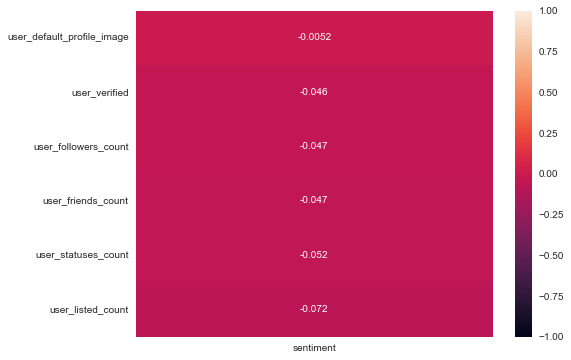

In [31]:
plt.figure(figsize=(8, 6))
plt.style.use('seaborn')

heatmap = sns.heatmap(dfusercorr[1:7], vmin=-1, vmax=1, annot=True)
# heatmap.set_title('Tf-idf features Correlating with Sentiment', fontdict={'fontsize':11}, pad=16)
plt.yticks(rotation = 360)
plt.savefig('user_corr', bbox_inches = 'tight', dpi = 300)

In [32]:
# df tweet
X_tweet = dftweet[(col for col in dftweet if col != 'sentiment')]
y_tweet = dftweet['sentiment']

X_train_tweet, X_test_tweet, y_train_tweet, y_test_tweet = train_test_split(X_tweet, y_tweet, test_size=0.20, random_state=seed)

# df user
X_user = dfuser[(col for col in dfuser if col != 'sentiment')]
y_user = dfuser['sentiment']

X_train_user, X_test_user, y_train_user, y_test_user = train_test_split(X_user, y_user, test_size=0.20, random_state=seed)

Training execution time is:  0:09:01.296001
{'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'n_estimators': 100}
Prediction execution time is:  0:00:00.203871
              precision    recall  f1-score   support

    positive       0.87      0.85      0.86      2470
    negative       0.86      0.87      0.87      2530

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

[[2110  360]
 [ 325 2205]]
Training execution time is:  0:01:07.524936
{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 50}
Prediction execution time is:  0:00:00.062944
              precision    recall  f1-score   support

    positive       0.85      0.88      0.87      2470
    negative       0.88      0.85      0.86      2530

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86     

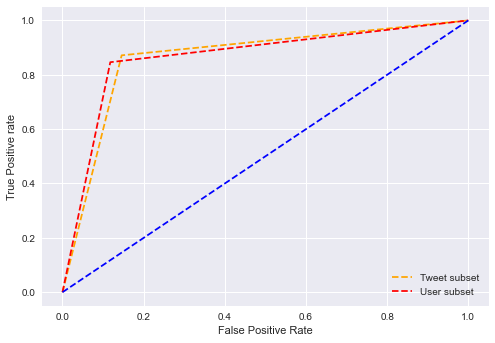

In [33]:
target_names = ['positive', 'negative']

start1 = datetime.now() 
rftweet = grid_rf.fit(X_train_tweet, y_train_tweet)
stop1 = datetime.now()
fit_execution_time_tweet = stop1-start1
print("Training execution time is: ", fit_execution_time_tweet)
print(rftweet.best_params_)
start2 = datetime.now() 
y_pred_tweet = rftweet.predict(X_test_tweet)
stop2 = datetime.now()
pred_execution_time_tweet = stop2-start2
print("Prediction execution time is: ", pred_execution_time_tweet)
print(classification_report(y_test_tweet, y_pred_tweet, target_names=target_names))
print(confusion_matrix(y_test_tweet, y_pred_tweet))

fpr1, tpr1, thresh1 = roc_curve(y_test_tweet, y_pred_tweet, pos_label=1)
auc_score1 = roc_auc_score(y_test_tweet, y_pred_tweet).round(2)

start1 = datetime.now() 
rfuser = grid_rf.fit(X_train_user, y_train_user)
stop1 = datetime.now()
fit_execution_time_user = stop1-start1
print("Training execution time is: ", fit_execution_time_user)
print(rfuser.best_params_)
start2 = datetime.now() 
y_pred_user = rfuser.predict(X_test_user)
stop2 = datetime.now()
pred_execution_time_user = stop2-start2
print("Prediction execution time is: ", pred_execution_time_user)
print(classification_report(y_test_user, y_pred_user, target_names=target_names))
print(confusion_matrix(y_test_user, y_pred_user))

fpr2, tpr2, thresh2 = roc_curve(y_test_user, y_pred_user, pos_label=1)
auc_score2 = roc_auc_score(y_test_user, y_pred_user).round(2)

print(auc_score1, auc_score2)

plt.style.use('seaborn')

plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Tweet subset')
plt.plot(fpr2, tpr2, linestyle='--',color='red', label='User subset')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# plt.title('Tweet vs. User ROC curve') # title
plt.xlabel('False Positive Rate') # x label
plt.ylabel('True Positive rate') # y label
plt.legend(loc='lower right')
plt.savefig('ROCsub',dpi=300)
plt.show();

Prediction execution time is:  0:00:00.062944
{'alpha': 0.001}
Prediction execution time is:  0:00:00.015622
              precision    recall  f1-score   support

    positive       0.72      0.66      0.69      2470
    negative       0.69      0.75      0.72      2530

    accuracy                           0.70      5000
   macro avg       0.71      0.70      0.70      5000
weighted avg       0.71      0.70      0.70      5000

[[1629  841]
 [ 634 1896]]
Prediction execution time is:  0:00:00.015622
{'alpha': 1}
Prediction execution time is:  0:00:00.007509
              precision    recall  f1-score   support

    positive       0.57      0.56      0.57      2470
    negative       0.58      0.58      0.58      2530

    accuracy                           0.57      5000
   macro avg       0.57      0.57      0.57      5000
weighted avg       0.57      0.57      0.57      5000

[[1390 1080]
 [1058 1472]]
0.7 0.57


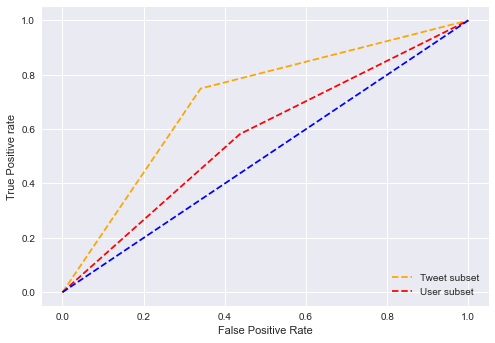

In [34]:
target_names = ['positive', 'negative']

start1 = datetime.now()
nbtweet = grid_nb.fit(X_train_tweet, y_train_tweet)
stop1 = datetime.now()
fit_execution_time_tweet_nb = stop2-start2
print("Prediction execution time is: ", fit_execution_time_tweet_nb)
print(nbtweet.best_params_)
start2 = datetime.now()
y_pred_tweet_nb = nbtweet.predict(X_test_tweet)
stop2 = datetime.now()
pred_execution_time_tweet_nb = stop2-start2
print("Prediction execution time is: ", pred_execution_time_tweet_nb)
print(classification_report(y_test_tweet, y_pred_tweet_nb, target_names=target_names))
print(confusion_matrix(y_test_tweet, y_pred_tweet_nb))

fpr3, tpr3, thresh3 = roc_curve(y_test_tweet, y_pred_tweet_nb, pos_label=1)
auc_score3 = roc_auc_score(y_test_tweet, y_pred_tweet_nb).round(2)

start1 = datetime.now()
nbuser = grid_nb.fit(X_train_user, y_train_user)
stop1 = datetime.now()
fit_execution_time_user_nb = stop2-start2
print("Prediction execution time is: ", fit_execution_time_user_nb)
print(nbuser.best_params_)
start2 = datetime.now()
y_pred_user_nb = nbuser.predict(X_test_user)
stop2 = datetime.now()
pred_execution_time_user_nb = stop2-start2
print("Prediction execution time is: ", pred_execution_time_user_nb)
print(classification_report(y_test_user, y_pred_user_nb, target_names=target_names))
print(confusion_matrix(y_test_user, y_pred_user_nb))

fpr4, tpr4, thresh4 = roc_curve(y_test_user, y_pred_user_nb, pos_label=1)
auc_score4= roc_auc_score(y_test_user, y_pred_user_nb).round(2)

print(auc_score3, auc_score4)

plt.style.use('seaborn')

plt.plot(fpr3, tpr3, linestyle='--',color='orange', label='Tweet subset')
plt.plot(fpr4, tpr4, linestyle='--',color='red', label='User subset')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# plt.title('Tweet vs. User ROC curve') # title
plt.xlabel('False Positive Rate') # x label
plt.ylabel('True Positive rate') # y label
plt.legend(loc='lower right')
plt.savefig('ROCsc',dpi=300)
plt.show();